# etude sur Alien vs Predator - épisode 4 : A New Hope

Développer un programme de vision par ordinateur capable de différencier avec précision un Alien d'un Predator.

Contexte du projet

L'épisode 3 a démontré que la technique de "transfer learning" pouvait augmenter de manière drastique les performances d'un CNN à effectuer de la classification d'images même sur un petit jeu de données. Il existe toutefois un léger sur-apprentissage résiduel. L'objectif de ce brief est de combiner la technique de "data augmentation" étudiée dans l'épisode 2 avec la technique de "features extraction" vue dans l'épisode 3 dans le but d'éliminer ce très léger sur-apprentissage résiduel ainsi que d'augmenter encore la précision du CNN.

Pour cela :

    Charger à nouveau le modèle VGG-16
        N.B. Ne pas oublier de "freezer" VGG-16 !
    Concaténer VGG-16 avec par exemple le perceptron multi-couches suivant

​

model.add(layers.Dense(units=256, activation='relu', input_dim=4 * 4 * 512))

model.add(layers.Dense(units=1, activation='sigmoid'))

​

N.B. Notons que l'architecture de ce MLP peut être optimisée : vous pouvez notamment tester un autre nombre de neurones dans la couche cachée.

​

    Entrainer l'ensemble en utilisant la technique de "data augmentation"
        ATTENTION AUX TEMPS DE CALCULS !!!


エピソード3では、転送学習を用いることで、少ないデータセットでもCNNの性能を飛躍的に向上させ、画像分類を行うことができることを示した。しかし、過学習が残っていることも事実です。本報告の目的は、第2話で検討したデータ増強技術と第3話で検討した特徴抽出技術を組み合わせることで、ごくわずかに残っている過学習を解消し、CNNの精度をさらに向上させることである。

そのために

    Charger à nouveau le modèle VGG-16
    N.B. Ne pas oublier de "freezer" VGG-16 !
    Concaténer VGG-16 avec par exemple le perceptron multi-couches suivant

N.B. このMLPのアーキテクチャは最適化できることに注意してください：特に，隠れ層のニューロン数を変えてテストすることが可能です．

データ補強の手法で全体を学習させる

    計算時間に注意!!!

1 - import librarys

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers 
from tensorflow.keras.layers import InputLayer, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import tensorflow

2 - set option pour l'affichage

In [2]:
pd.set_option("max_columns", None)
pd.set_option("max_colwidth", None)
pd.set_option("max_row", 500)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3 - charger des images

In [4]:
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/2022_02_08_ep4_Alien_Predator/'

TRAINING_DIR = dataset_dir + 'Data/Train/'
VALIDATION_DIR = dataset_dir + 'Data/Validation/'
TEST_DIR = dataset_dir + 'Data/Test/'

In [5]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
augmented_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [7]:
train_generator = augmented_datagen.flow_from_directory(TRAINING_DIR,
                                            target_size = (150, 150),                                             
                                            batch_size = 494,
                                            class_mode="binary" 
                                             )

Found 494 images belonging to 2 classes.


In [8]:
val_generator = datagen.flow_from_directory(VALIDATION_DIR,
                                            target_size=(150, 150),
                                            batch_size = 200,
                                            class_mode="binary"                                       
                                           )

Found 200 images belonging to 2 classes.


In [9]:
test_generator = datagen.flow_from_directory(TEST_DIR,
                                            target_size=(150, 150),
                                            batch_size = 200,
                                            class_mode="binary"                                        
                                           )

Found 200 images belonging to 2 classes.


In [10]:
X_train = train_generator[0][0]
y_train=  train_generator[0][1]

In [11]:
X_val = val_generator[0][0]
y_val = val_generator[0][1]

In [12]:
X_test = test_generator[0][0]
y_test = test_generator[0][1]

In [13]:
type(X_test)

numpy.ndarray

#### save X_test et y_test in numpy

In [14]:
np.save(dataset_dir + 'X_test', X_test)
np.save(dataset_dir + 'y_test', y_test)

In [15]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((494, 150, 150, 3),
 (494,),
 (200, 150, 150, 3),
 (200,),
 (200, 150, 150, 3),
 (200,))

In [16]:
IMG_SHAPE = (150, 150, 3)
base_model = VGG16(input_shape = IMG_SHAPE, include_top = False,
            weights="imagenet")
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [17]:
input_shape = (150, 150, 3)

In [18]:
# VGG16から全結合層を除く
conv_layers = VGG16(include_top=False, weights='imagenet', input_shape=input_shape, input_tensor=None,)
conv_layers.trainable = False  # 学習させない (学習済みの重みを使う)

In [19]:
conv_layers.trainable

False

In [20]:
conv_layers.trainable_weights

[]

In [21]:
conv_layers.non_trainable_weights

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
    

In [22]:
# VGG16に全結合層を追加
model = Sequential()
model.add(conv_layers)
model.add(Flatten())
model.add(Dense(units=256, activation='relu', input_dim=4 * 4 * 512))
model.add(Dense(units=1, activation='sigmoid'))

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [25]:
history = model.fit(
          train_generator, # augumanter_generator のときは、 X_trainでない
          epochs = 100,
          validation_data = val_generator, 
          steps_per_epoch=1,
          validation_steps=1
         )

Epoch 1/100
1/1 [==============================] - 40s 40s/step - loss: 4.0911 - accuracy: 0.4879 - val_loss: 20.9905 - val_accuracy: 0.5700
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 19.2053 - accuracy: 0.5749 - val_loss: 6.6117 - val_accuracy: 0.7500
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 3.7761 - accuracy: 0.8158 - val_loss: 10.8148 - val_accuracy: 0.6450
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 5.9300 - accuracy: 0.7328 - val_loss: 3.6662 - val_accuracy: 0.8300
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 2.0602 - accuracy: 0.8563 - val_loss: 1.1115 - val_accuracy: 0.8800
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 1.3005 - accuracy: 0.8745 - val_loss: 1.4486 - val_accuracy: 0.8600
Epoch 7/100
1/1 [==============================] - 6s 6s/step - loss: 1.2588 - accuracy: 0.8704 - val_loss: 1.8723 - val_accuracy: 0.8650
Epoch 8/100
1/1 [============

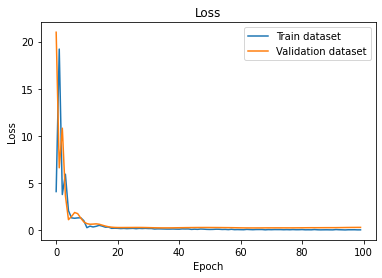

In [26]:
plt.title('Loss')
plt.plot(history.history['loss'], label='Train dataset')
plt.plot(history.history['val_loss'], label='Validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

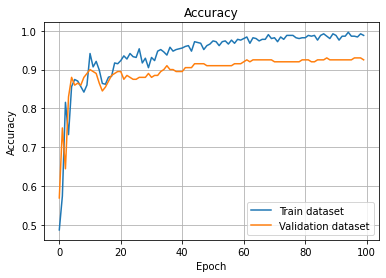

In [27]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train dataset')
plt.plot(history.history['val_accuracy'], label='Validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

#### confusion matrix

In [28]:
y_train_pred = model.predict(X_train)
y_train_pred  = y_train_pred > 0.5

cm_train = confusion_matrix(y_train, y_train_pred)
cm_train

array([[244,   3],
       [  3, 244]])

In [29]:
y_val_pred = model.predict(X_val)
y_val_pred  = y_val_pred > 0.5

cm_val = confusion_matrix(y_val, y_val_pred)
cm_val

array([[92,  8],
       [ 7, 93]])

In [30]:
target_names = ['Alien 0', 'Predator 1']
print(classification_report(y_train, y_train_pred, target_names=target_names))

              precision    recall  f1-score   support

     Alien 0       0.99      0.99      0.99       247
  Predator 1       0.99      0.99      0.99       247

    accuracy                           0.99       494
   macro avg       0.99      0.99      0.99       494
weighted avg       0.99      0.99      0.99       494



In [31]:
target_names = ['Alien 0', 'Predator 1']
print(classification_report(y_val, y_val_pred, target_names=target_names))

              precision    recall  f1-score   support

     Alien 0       0.93      0.92      0.92       100
  Predator 1       0.92      0.93      0.93       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200



### save model

In [32]:
model.save('/content/drive/MyDrive/Colab Notebooks/2022_02_08_ep4_Alien_Predator/' + 'model_ep4')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/2022_02_08_ep4_Alien_Predator/model_ep4/assets
